<a href="https://colab.research.google.com/github/EduHdzVillasana/COVIDSTATSMX/blob/master/An%C3%A1lisis%20y%20Modelado/Modelo_Predictorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación de modelo para predecir probabilidad de muerte por COVID-19
En este notebook se creará un modelo de regresión logística para predecir la probabilidad de muerte de un paciente positivo a sars-cov-2 dadas sus condiciones.

También se creará un modelo para predecir la probabilidad de contraer enfermedad grave dadas sus condiciones y así identificar personas vulnerables.

## Librerías a utilizar


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

# Librerias para la regresión logística
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from tabulate import tabulate
from sklearn import linear_model
from sklearn import preprocessing

# Librerias para la validación del modelo
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
mainpath = "/content/drive/MyDrive/Datos Abiertos"
filepath = "210401COVID19MEXICO_filtered.csv"

data = pd.read_csv(os.path.join(mainpath, filepath), index_col=0)
data.sample(3);

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
columns = ['EDAD', 'EMBARAZO','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'TIEMPO_ESPERA', 'HOSPITALIZADO','SEXO_','SECTOR_ATENDIDO','ESTADO','ENFERMEDAD_GRAVE','FALLECIDO']
data = data[columns]

## Preparación de datos

In [6]:
data = data.rename({"SEXO_":"SEXO"}, axis = 1)

In [7]:
data.columns

Index(['EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
       'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'TIEMPO_ESPERA', 'HOSPITALIZADO', 'SEXO',
       'SECTOR_ATENDIDO', 'ESTADO', 'ENFERMEDAD_GRAVE', 'FALLECIDO'],
      dtype='object')

### Creación de variables dummies (catagóricas)

In [8]:
categories = ["SEXO","SECTOR_ATENDIDO","ESTADO"]
for cat in categories:
  cat_dummies = pd.get_dummies(data[cat], prefix = cat)
  data = data.join(cat_dummies)

In [9]:
data.columns

Index(['EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
       'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'TIEMPO_ESPERA', 'HOSPITALIZADO', 'SEXO',
       'SECTOR_ATENDIDO', 'ESTADO', 'ENFERMEDAD_GRAVE', 'FALLECIDO',
       'SEXO_HOMBRE', 'SEXO_MUJER', 'SECTOR_ATENDIDO_CRUZ ROJA',
       'SECTOR_ATENDIDO_DIF', 'SECTOR_ATENDIDO_ESTATAL',
       'SECTOR_ATENDIDO_IMSS', 'SECTOR_ATENDIDO_IMSS-BIENESTAR',
       'SECTOR_ATENDIDO_ISSSTE', 'SECTOR_ATENDIDO_MUNICIPAL',
       'SECTOR_ATENDIDO_PEMEX', 'SECTOR_ATENDIDO_PRIVADA',
       'SECTOR_ATENDIDO_SEDENA', 'SECTOR_ATENDIDO_SEMAR',
       'SECTOR_ATENDIDO_SSA', 'SECTOR_ATENDIDO_UNIVERSITARIO', 'ESTADO_AS',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'E

In [10]:
# Columnas de las condiciones del paciente ántes de ser atendido por una institución de salud
before_columns = ['EDAD', 'EMBARAZO','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'ESTADO_AS','SEXO_HOMBRE', 'SEXO_MUJER',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'ESTADO_PL',
       'ESTADO_QR', 'ESTADO_QT', 'ESTADO_SL', 'ESTADO_SP', 'ESTADO_SR',
       'ESTADO_TC', 'ESTADO_TL', 'ESTADO_TS', 'ESTADO_VZ', 'ESTADO_YN',
       'ESTADO_ZS']

# Columnas de las condiciones del paciente después de ser atendido por una institución de salud
after_columns = ['EDAD', 'EMBARAZO','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'TIEMPO_ESPERA', 'HOSPITALIZADO','SEXO_HOMBRE', 'SEXO_MUJER', 'SECTOR_ATENDIDO_CRUZ ROJA',
       'SECTOR_ATENDIDO_DIF', 'SECTOR_ATENDIDO_ESTATAL', 'SECTOR_ATENDIDO_IMSS', 'SECTOR_ATENDIDO_IMSS-BIENESTAR',
       'SECTOR_ATENDIDO_ISSSTE', 'SECTOR_ATENDIDO_MUNICIPAL', 'SECTOR_ATENDIDO_PEMEX', 'SECTOR_ATENDIDO_PRIVADA',
       'SECTOR_ATENDIDO_SEDENA', 'SECTOR_ATENDIDO_SEMAR', 'SECTOR_ATENDIDO_SSA', 'SECTOR_ATENDIDO_UNIVERSITARIO', 'ESTADO_AS',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'ESTADO_PL',
       'ESTADO_QR', 'ESTADO_QT', 'ESTADO_SL', 'ESTADO_SP', 'ESTADO_SR',
       'ESTADO_TC', 'ESTADO_TL', 'ESTADO_TS', 'ESTADO_VZ', 'ESTADO_YN',
       'ESTADO_ZS']



### Eliminación de outlier
Se identificó que una columna posiblemente tenga datos atípicos. La columna `TIEMPO_ESPERA`

In [11]:
def summary(data):
  minimo = data.min()
  Q1 = data.quantile(0.25)
  median = data.median()
  mean = data.mean()
  Q2 = data.quantile(0.5)
  Q3 = data.quantile(0.75)
  maximo = data.max()
  IQR = Q3 - Q1
  resumen = {'minimo': minimo, 'Q1': Q1, 'mediana':median,'Q2':Q2,'Q3':Q3,'max':maximo,'IQR':IQR, 'media':mean}
  return resumen

In [12]:
print ("Resumen TIEMPO_ESPERA")
time_summary = summary(data["TIEMPO_ESPERA"])
time_summary

Resumen TIEMPO_ESPERA


{'IQR': 4.0,
 'Q1': 2.0,
 'Q2': 3.0,
 'Q3': 6.0,
 'max': 174,
 'media': 4.076062198742845,
 'mediana': 3.0,
 'minimo': 0}

{'boxes': [<matplotlib.lines.Line2D at 0x7f9cfa1bbbd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f9cfb73ee10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9cfbca7e50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9cfaaf85d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9cfa1bb550>,
  <matplotlib.lines.Line2D at 0x7f9cfb73e450>]}

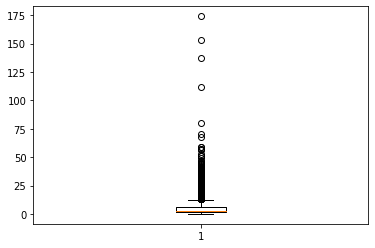

In [13]:
plt.boxplot(data["TIEMPO_ESPERA"])

In [14]:
data = data[data["TIEMPO_ESPERA"] <= time_summary["Q3"] + 1.5*time_summary["IQR"]]

### Normalización de datos numéroicos
Se normalizarán las variables de `EDAD` y `TIEMPO_ESPERA`

In [15]:
data["EDAD"].describe()

count    2.163626e+06
mean     4.355414e+01
std      1.700503e+01
min      0.000000e+00
25%      3.000000e+01
50%      4.200000e+01
75%      5.500000e+01
max      1.210000e+02
Name: EDAD, dtype: float64

In [16]:
scaled = preprocessing.MinMaxScaler()
scaled_edad = scaled.fit_transform(data["EDAD"].values.reshape(-1,1))
data["EDAD"] = scaled_edad

In [17]:
data["EDAD"].describe()

count    2.163626e+06
mean     3.599515e-01
std      1.405374e-01
min      0.000000e+00
25%      2.479339e-01
50%      3.471074e-01
75%      4.545455e-01
max      1.000000e+00
Name: EDAD, dtype: float64

In [18]:
data["TIEMPO_ESPERA"].describe()

count    2.163626e+06
mean     3.780447e+00
std      2.834329e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      1.200000e+01
Name: TIEMPO_ESPERA, dtype: float64

In [19]:
scaled = preprocessing.MinMaxScaler()
scaled_time = scaled.fit_transform(data["TIEMPO_ESPERA"].values.reshape(-1,1))
data["TIEMPO_ESPERA"] = scaled_time

In [20]:
data["TIEMPO_ESPERA"].describe()

count    2.163626e+06
mean     3.150373e-01
std      2.361941e-01
min      0.000000e+00
25%      1.666667e-01
50%      2.500000e-01
75%      5.000000e-01
max      1.000000e+00
Name: TIEMPO_ESPERA, dtype: float64

**Formula Edad Normalizada:**

$\large{E_N=\frac{E}{121}}$
******
**Formula Tiempo de espera Normalizado:**

$\large{T_N=\frac{T}{12}}$

## Modelo para condiciones iniciales del paciente


### Selección de las varianbles

In [21]:
X_before = data[before_columns].copy()
Y_deceased = data["FALLECIDO"].copy()
len(before_columns)

46

In [22]:
data.columns

Index(['EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
       'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'TIEMPO_ESPERA', 'HOSPITALIZADO', 'SEXO',
       'SECTOR_ATENDIDO', 'ESTADO', 'ENFERMEDAD_GRAVE', 'FALLECIDO',
       'SEXO_HOMBRE', 'SEXO_MUJER', 'SECTOR_ATENDIDO_CRUZ ROJA',
       'SECTOR_ATENDIDO_DIF', 'SECTOR_ATENDIDO_ESTATAL',
       'SECTOR_ATENDIDO_IMSS', 'SECTOR_ATENDIDO_IMSS-BIENESTAR',
       'SECTOR_ATENDIDO_ISSSTE', 'SECTOR_ATENDIDO_MUNICIPAL',
       'SECTOR_ATENDIDO_PEMEX', 'SECTOR_ATENDIDO_PRIVADA',
       'SECTOR_ATENDIDO_SEDENA', 'SECTOR_ATENDIDO_SEMAR',
       'SECTOR_ATENDIDO_SSA', 'SECTOR_ATENDIDO_UNIVERSITARIO', 'ESTADO_AS',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'E

Nos quedaremos con la mitad de las variables 

Se utiliza el solver sag porque es más rápido para datasets grandes (en variables y tamaño de la muestra)

* [Referencia 1](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions)
* [Referencia 2](https://rubialesalberto.medium.com/regresi%C3%B3n-log%C3%ADstica-con-sklearn-4384c707075d)

In [ ]:
n = 23
lr = linear_model.LogisticRegression(solver="saga")
rfe = RFE(lr,n)
rfe = rfe.fit(X_before,Y_deceased)

In [ ]:
var_included = list(zip(before_columns, rfe.support_, rfe.ranking_))
var_included.sort(key = lambda x: x[2])
print (tabulate(var_included))

--------------  -  --
EDAD            1   1
DIABETES        1   1
INMUSUPR        1   1
HIPERTENSION    1   1
OTRA_COM        1   1
OBESIDAD        1   1
RENAL_CRONICA   1   1
SEXO_HOMBRE     1   1
SEXO_MUJER      1   1
ESTADO_BC       1   1
ESTADO_BS       1   1
ESTADO_CH       1   1
ESTADO_CS       1   1
ESTADO_DF       1   1
ESTADO_HG       1   1
ESTADO_MC       1   1
ESTADO_NT       1   1
ESTADO_PL       1   1
ESTADO_QR       1   1
ESTADO_SL       1   1
ESTADO_TC       1   1
ESTADO_TL       1   1
ESTADO_VZ       1   1
ESTADO_OC       0   2
ESTADO_QT       0   3
ESTADO_NL       0   4
ESTADO_DG       0   5
ESTADO_SP       0   6
ESTADO_GT       0   7
ESTADO_SR       0   8
ESTADO_MS       0   9
EPOC            0  10
ESTADO_CC       0  11
ASMA            0  12
ESTADO_TS       0  13
ESTADO_ZS       0  14
ESTADO_AS       0  15
ESTADO_GR       0  16
TABAQUISMO      0  17
ESTADO_JC       0  18
EMBARAZO        0  19
ESTADO_CL       0  20
ESTADO_MN       0  21
ESTADO_CM       0  22
ESTADO_YN 

#### Variables escogidas

In [23]:
before_columns = ['EDAD', 'DIABETES', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'OBESIDAD', 'RENAL_CRONICA', 'SEXO_HOMBRE', 'SEXO_MUJER',
 'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CH', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_HG', 'ESTADO_MC', 'ESTADO_NT', 'ESTADO_PL', 'ESTADO_QR',
 'ESTADO_SL', 'ESTADO_TC', 'ESTADO_TL', 'ESTADO_VZ']

In [24]:
#before_columns = [v[0] for v in var_included if v[1] == True]
before_columns

['EDAD',
 'DIABETES',
 'INMUSUPR',
 'HIPERTENSION',
 'OTRA_COM',
 'OBESIDAD',
 'RENAL_CRONICA',
 'SEXO_HOMBRE',
 'SEXO_MUJER',
 'ESTADO_BC',
 'ESTADO_BS',
 'ESTADO_CH',
 'ESTADO_CS',
 'ESTADO_DF',
 'ESTADO_HG',
 'ESTADO_MC',
 'ESTADO_NT',
 'ESTADO_PL',
 'ESTADO_QR',
 'ESTADO_SL',
 'ESTADO_TC',
 'ESTADO_TL',
 'ESTADO_VZ']

### Separación de datasets para entrenamiento y prueba

In [25]:
X_before = data[before_columns].copy()

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X_before, Y_deceased, test_size = 0.3, random_state = 442021)

### Creación de modelo de regresión logística

In [27]:
lm_before = linear_model.LogisticRegression(solver="saga")
lm_before.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
lm_before.score(X_test, Y_test)

0.9143613808913429

In [29]:
lm_before.score(X_before,Y_deceased)

0.9141598409336918

In [30]:
lm_before.intercept_

array([-6.83220873])

In [31]:
params = list(zip(X_before.columns, np.transpose(lm_before.coef_)))
params.append(("INTERCEPCION", lm_before.intercept_))
print(tabulate(params))

-------------  ---------
EDAD            9.22962
DIABETES        0.553748
INMUSUPR        0.468485
HIPERTENSION    0.271243
OTRA_COM        0.708996
OBESIDAD        0.492743
RENAL_CRONICA   1.15805
SEXO_HOMBRE     0.301037
SEXO_MUJER     -0.317381
ESTADO_BC       0.636111
ESTADO_BS      -0.479857
ESTADO_CH       0.39717
ESTADO_CS       0.421029
ESTADO_DF      -0.395616
ESTADO_HG       0.706101
ESTADO_MC       0.879911
ESTADO_NT       0.39637
ESTADO_PL       0.401868
ESTADO_QR       0.498683
ESTADO_SL       0.459068
ESTADO_TC      -0.349068
ESTADO_TL       0.54112
ESTADO_VZ       0.512763
INTERCEPCION   -6.83221
-------------  ---------


In [32]:
probs = lm_before.predict_proba(X_test)

In [33]:
ps = []
for p in probs:
  ps.append(p[1]) # La columna 0 del array contiene la prob de que el evento 0 ocurra, lo mismo para la 1
ps[0:5]

[0.019490890747932924,
 0.0019296566588356944,
 0.041382834956198426,
 0.0038810739082932883,
 0.004874160979220878]

### Validación del modelo
No se usarán Matrices de Confusión ni curvas ROC por que el objetivo no es clasificar, si no obtener un modelo para predecir la probabilidad de muerte.

In [34]:
prediction = lm_before.predict(X_test)

In [35]:
metrics.accuracy_score(Y_test,prediction)

0.9143613808913429

#### Validación Cruzada

In [36]:
scores = cross_val_score(linear_model.LogisticRegression(solver="saga"), X_before, Y_deceased, scoring = "accuracy", cv = 10)
# Toma 11 minutos

In [37]:
scores 

array([0.9142321 , 0.91483294, 0.91163461, 0.84640165, 0.48261949,
       0.77533589, 0.69945739, 0.90708165, 0.79067951, 0.91382036])

In [38]:
scores.mean()

0.815609559415846

### Exportación de modelo


In [40]:
import pickle

In [39]:
mainpath = "/content/drive/MyDrive/Modelos"
filename = "LR_before.sav"

In [42]:
pickle.dump(lm_before, open(os.path.join(mainpath,filename),'wb'))

In [43]:
# Prueba de modelo guardad
loaded_model = pickle.load( open(os.path.join(mainpath,filename),'rb'))

In [46]:
loaded_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
params = list(zip(X_before.columns, np.transpose(loaded_model.coef_)))
params.append(("INTERCEPCION", loaded_model.intercept_))
print(tabulate(params))

-------------  ---------
EDAD            9.22962
DIABETES        0.553748
INMUSUPR        0.468485
HIPERTENSION    0.271243
OTRA_COM        0.708996
OBESIDAD        0.492743
RENAL_CRONICA   1.15805
SEXO_HOMBRE     0.301037
SEXO_MUJER     -0.317381
ESTADO_BC       0.636111
ESTADO_BS      -0.479857
ESTADO_CH       0.39717
ESTADO_CS       0.421029
ESTADO_DF      -0.395616
ESTADO_HG       0.706101
ESTADO_MC       0.879911
ESTADO_NT       0.39637
ESTADO_PL       0.401868
ESTADO_QR       0.498683
ESTADO_SL       0.459068
ESTADO_TC      -0.349068
ESTADO_TL       0.54112
ESTADO_VZ       0.512763
INTERCEPCION   -6.83221
-------------  ---------


## Modelo para condiciones post valoración médica.
Se agregan tres variables.
* `TIEMPO_ESPERA`: Mide el tiempo que pasó entre el inicio de los sintomas y el ingreso al sector médico
* `HOSPITALIZADO`: Indica si el paciente fue hospitalizado o su atención fue ambulatoria.
* `SEXTOR`: Variable categórica que indica el sector de salud que atendió al paciente.

### Selección de las variables

In [48]:
X_after = data[after_columns].copy()
Y_deceased = data["FALLECIDO"].copy()
len(after_columns)

61

In [50]:
X_after.columns

Index(['EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
       'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'TIEMPO_ESPERA', 'HOSPITALIZADO',
       'SEXO_HOMBRE', 'SEXO_MUJER', 'SECTOR_ATENDIDO_CRUZ ROJA',
       'SECTOR_ATENDIDO_DIF', 'SECTOR_ATENDIDO_ESTATAL',
       'SECTOR_ATENDIDO_IMSS', 'SECTOR_ATENDIDO_IMSS-BIENESTAR',
       'SECTOR_ATENDIDO_ISSSTE', 'SECTOR_ATENDIDO_MUNICIPAL',
       'SECTOR_ATENDIDO_PEMEX', 'SECTOR_ATENDIDO_PRIVADA',
       'SECTOR_ATENDIDO_SEDENA', 'SECTOR_ATENDIDO_SEMAR',
       'SECTOR_ATENDIDO_SSA', 'SECTOR_ATENDIDO_UNIVERSITARIO', 'ESTADO_AS',
       'ESTADO_BC', 'ESTADO_BS', 'ESTADO_CC', 'ESTADO_CH', 'ESTADO_CL',
       'ESTADO_CM', 'ESTADO_CS', 'ESTADO_DF', 'ESTADO_DG', 'ESTADO_GR',
       'ESTADO_GT', 'ESTADO_HG', 'ESTADO_JC', 'ESTADO_MC', 'ESTADO_MN',
       'ESTADO_MS', 'ESTADO_NL', 'ESTADO_NT', 'ESTADO_OC', 'ESTADO_PL',
       'ESTADO_QR', 'ESTADO_QT', 'ESTADO_SL', 'ESTADO_SP', 'ESTADO